In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import pytorch_lightning as pl

import torch
from torch import optim

from bliss.models import encoder, decoder, flux_net
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import plotting_utils 

device = "cuda:4"
print(device)


# _ = torch.manual_seed(34)


cuda:4


# Load dataset

In [2]:
overrides = {'model':"sleep_sdss_measure_simple", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
cfg.dataset.kwargs

{'decoder_kwargs': '${model.kwargs.decoder_kwargs}', 'n_batches': 10, 'batch_size': 32, 'generate_device': 'cuda:0', 'testing_file': None}

In [4]:
# set device
cfg.dataset.kwargs.update({'generate_device': device})

In [5]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

In [6]:
cfg.training.n_epochs

121

### some sample images

In [7]:
test_dataloader = dataset.test_dataloader()

In [8]:
for _, batch in enumerate(test_dataloader):
    break

In [9]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [10]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * dataset.image_decoder.slen + \
                dataset.image_decoder.border_padding - 0.5
    
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [11]:
%matplotlib inline

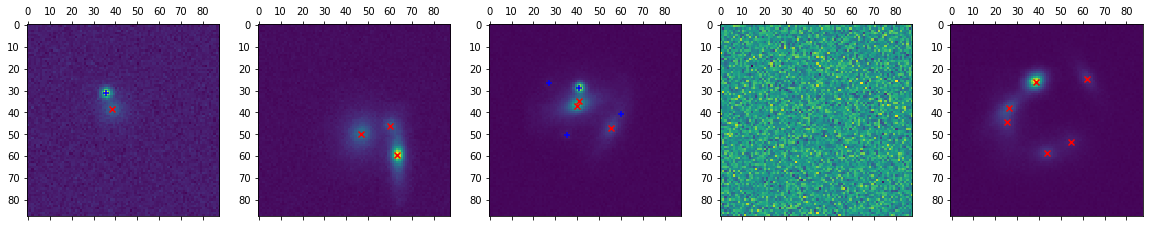

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for indx in range(batch['images'].shape[0]):
    
    if indx > 4: 
        break
        
    # plot image 
    axes[indx].matshow(batch['images'][indx, 0].cpu())

    # plot parameters
    plot_params(true_params, indx, axes[indx])

# Define encoder

In [13]:
flux_estimator = flux_net.FluxEstimator(cfg.model.kwargs.decoder_kwargs, 
                                        optimizer_params=cfg.optimizer)
flux_estimator.to(device);

### Initial loss

In [14]:
def eval_loss(): 
    loss = 0
    counter = 0
    target = 0

    for _, batch in enumerate(test_dataloader):
        
        # estimated loss
        loss += flux_estimator.get_loss(batch)

        # loss under the truth
        target += flux_estimator.kl_qp_flux_loss( 
                        batch,
                        batch['fluxes'], 
                        # set the sd to 1
                        batch['fluxes'] * 0. + 1.0)[0].mean()

        counter += 1

    print('loss: {}'.format(loss / counter))
    print('target: {}'.format(target / counter))

In [15]:
eval_loss()

loss: 258340.359375
target: 37313.91796875


# Optimize

In [16]:
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [ ]:
t0 = time.time()
trainer.fit(flux_estimator, datamodule = dataset)


  | Name          | Type         | Params
-----------------------------------------------
0 | image_decoder | ImageDecoder | 54.6 K
1 | enc           | FluxEncoder  | 212 K 


Epoch 9: : 5it [00:01,  3.26it/s, loss=43431.820, v_num=23]           

# Evaluate

In [ ]:
flux_estimator.to(device);

In [ ]:
eval_loss()

In [ ]:
for _, test_batch in enumerate(test_dataloader):
    break

In [ ]:
# get estimates
out = flux_estimator(test_batch['images'])

# get loss
_, recon = flux_estimator.kl_qp_flux_loss(test_batch,
                                             out['mean'], 
                                             out['sd'])

In [ ]:
_true_tile_dict = dict(locs = test_batch['locs'],
                       n_sources = test_batch['n_sources'],
                       galaxy_bool = test_batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [ ]:
for indx in range(20):

    fig, ax = plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                            recon[indx, 0], 
                                            resid_fun=lambda x, y : (x - y) / torch.sqrt(y))
    
    # plot parameters
    plot_params(true_params, indx, ax[0])

In [ ]:
is_star = get_star_bool(test_batch['n_sources'], test_batch['galaxy_bool']) == 1

truth = test_batch['fluxes'][is_star].cpu().numpy()
est = out['mean'][is_star].cpu().detach().numpy()

In [ ]:
plt.scatter(np.log10(truth), 
            np.log10(est))

plt.plot(np.log10(truth), 
         np.log10(truth), 
         color = 'red')